<a href="https://colab.research.google.com/github/teamsimcoemmai/mmai894/blob/894-GavinLei/Final%20Project/ResNet152_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The experiment inspired by Sean Sungil Kim's work:  
https://github.com/kimx3314/Stanford-Cars-Dataset-Vehicle-Recognition

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from glob import iglob
from IPython.core.display import Image, display
import cv2
import time
from fastai.callbacks import *

In [ ]:
def random_seed(seed_value, use_cuda):  #gleaned from multiple forum posts
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: torch.cuda.manual_seed_all(seed_value) # gpu 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load datasets
random_seed(42,True)
data = ImageDataBunch.from_folder('/content/drive/MyDrive/Simcoe/894/Car dataset/new','train_set','val_set','test_set', seed=42,
                                  ds_tfms=get_transforms(do_flip=False, 
                                                         flip_vert=True, 
                                                         p_affine=0.75, # Default value
                                                         max_rotate=5.0, 
                                                         max_zoom=1.1,
                                                         max_warp=0.2,
                                                         p_lighting=0.75, # Defalut value 
                                                         max_lighting=0.2,                                                                                                                  ),
                                                         size=224,
                                                         bs=32).normalize(imagenet_stats)
                                                  

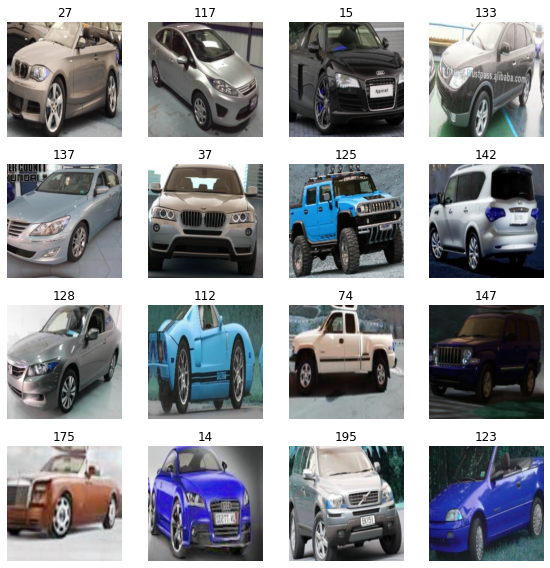

In [ ]:
# preview of training data generated from ImageDataBunch
data.show_batch(rows = 4, figsize = (8, 8))

In [ ]:
# Load ResNet152 base model
random_seed(42,True)
learn = cnn_learner(data, models.resnet152, pretrained = True, metrics = accuracy,\
                    callback_fns = ShowGraph, model_dir = "/content/drive/MyDrive/894GroupProject/ResNet152/1/")

learn.summary()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.

Total wd and lr analysis runtime: 613.5171122550964


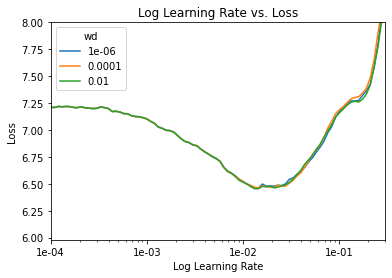

In [ ]:
# Tuning Learning Rate and Weight Decay
lr_List = []
loss_List = []
wd_List = [1e-6, 1e-4, 1e-2]

start_ts = time.time()

for wd in wd_List:
    random_seed(42,True)
    exp_learn = cnn_learner(data, models.resnet152, pretrained = True, metrics = accuracy,\
                            model_dir = "/content/drive/MyDrive/894GroupProject/ResNet152/2/")
    random_seed(42,True)
    exp_learn.lr_find(wd = wd, num_it = 200)
    lr_List.append(exp_learn.recorder.lrs)
    loss_List.append(exp_learn.recorder.losses)

min_y = 6
max_y = 8
_, ax = plt.subplots(1, 1)
for i in range(len(loss_List)):
    ax.plot(lr_List[i], loss_List[i])
    min_y = min(np.asarray(loss_List[i]).min(), min_y)
ax.set_title('Log Learning Rate vs. Loss'), ax.set_ylabel('Loss'), ax.set_xlabel('Log Learning Rate')
ax.set_xscale('log'), ax.set_xlim((1e-4,3e-1)), ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wd_List, title = 'wd'), ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
print("\nTotal wd and lr analysis runtime:", time.time() - start_ts)


epoch,train_loss,valid_loss,accuracy,time
0,2.942568,2.274796,0.432455,12:04
1,2.841012,2.585961,0.363262,01:55
2,2.052103,1.975700,0.491351,01:54
3,1.684476,1.717565,0.537068,01:54
4,1.233059,1.110421,0.689044,01:54
5,0.951891,0.761813,0.787479,01:55
6,0.657518,0.570527,0.837727,01:54
7,0.404285,0.446601,0.865733,01:55
8,0.299975,0.388844,0.889621,01:54
9,0.234102,0.375038,0.894152,01:55


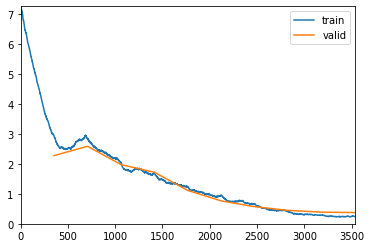

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet152_phase1.pth')

In [ ]:
# Top Layer Training
random_seed(42,True)
learn.fit_one_cycle(10, max_lr = 1e-2, wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet152_phase1', return_path = True)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


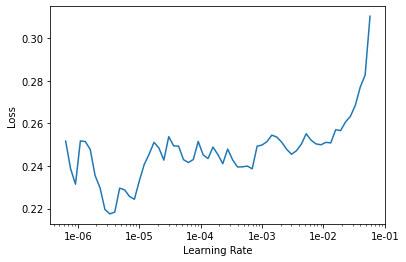

In [ ]:
# Check Loss when WD=1e-2
random_seed(42,True)
learn.lr_find(wd = 1e-2)
learn.recorder.plot()


epoch,train_loss,valid_loss,accuracy,time
0,1.894749,2.384306,0.441928,02:35
1,1.935052,5.293692,0.230642,02:35
2,1.904239,3.251938,0.308896,02:35
3,1.503470,1.572483,0.581137,02:35
4,1.106850,1.072741,0.698929,02:35
5,0.875789,0.769252,0.780478,02:35
6,0.649201,0.574210,0.842257,02:35
7,0.372659,0.405240,0.888797,02:35
8,0.296678,0.358830,0.893328,02:35
9,0.243849,0.350524,0.900329,02:35


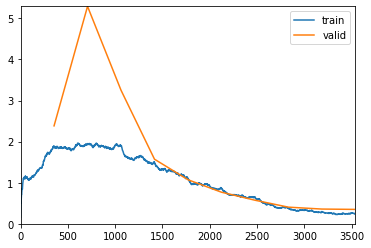

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet152_phase21.pth')

In [ ]:
#Unfreeze the model and full training
#Experiment1 by setting max_lr = slice(1e-3, 1e-2)
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet152_phase1')
learn.unfreeze()
random_seed(42,True)
learn.fit_one_cycle(10, max_lr = slice(1e-3, 1e-2), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet152_phase21', return_path = True)


epoch,train_loss,valid_loss,accuracy,time
0,0.563655,0.728262,0.802306,02:35
1,0.941382,1.278437,0.659802,02:34
2,0.792220,1.331344,0.655272,02:35
3,0.497639,1.186071,0.717051,02:34
4,0.331723,0.613804,0.818781,02:35
5,0.232382,0.533723,0.851318,02:34
6,0.161069,0.424933,0.876853,02:35
7,0.136804,0.355209,0.896623,02:35
8,0.153549,0.313713,0.908155,02:35
9,0.160550,0.310137,0.907743,02:35


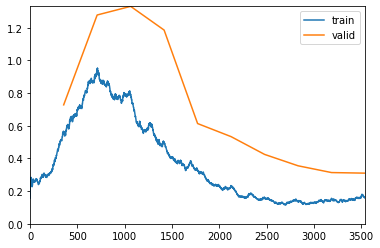

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet152_phase22.pth')

In [ ]:
#Unfreeze the model and full training
#Experiment2 by setting max_lr = slice(1e-4, 1e-3)
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet152_phase1')
learn.unfreeze()
random_seed(42,True)
learn.fit_one_cycle(10, max_lr = slice(1e-4, 1e-3), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet152_phase22', return_path = True)


epoch,train_loss,valid_loss,accuracy,time
0,0.226770,0.376552,0.889209,02:35
1,0.265619,0.445686,0.871911,02:35
2,0.250845,0.474626,0.863674,02:35
3,0.145458,0.453603,0.873558,02:35
4,0.080332,0.418125,0.876853,02:34
5,0.053071,0.396261,0.889621,02:34
6,0.038351,0.358173,0.890033,02:35
7,0.043668,0.358586,0.898270,02:34
8,0.081164,0.338395,0.907331,02:35
9,0.117783,0.333984,0.908155,02:34


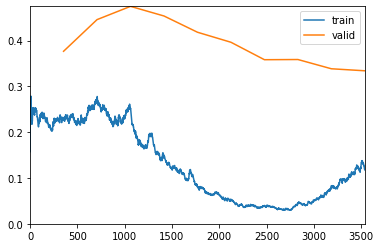

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet152_phase23.pth')

In [ ]:
#Unfreeze the model and full training
#Experiment3 by setting max_lr = slice(1e-5, 1e-4)
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet152_phase1')
learn.unfreeze()
random_seed(42,True)
learn.fit_one_cycle(10, max_lr = slice(1e-5, 1e-4), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet152_phase23', return_path = True)

epoch,train_loss,valid_loss,accuracy,time
0,1.052962,1.453492,0.631384,02:35
1,1.401224,1.833520,0.537891,02:35
2,1.134492,1.942578,0.540774,02:35
3,0.786927,1.363062,0.666392,02:35
4,0.520837,0.816802,0.765651,02:35
5,0.400146,1.326167,0.812191,02:35
6,0.285820,0.463051,0.870675,02:35
7,0.228759,0.376679,0.891680,02:35
8,0.206190,0.607533,0.893740,02:35
9,0.181446,0.515192,0.901565,02:35


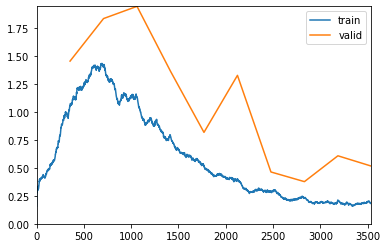

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet152_phase23.pth')

In [ ]:
#Unfreeze the model and full training
#Experiment4 by setting max_lr = slice(3e-4, 3e-3)
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet152_phase1')
learn.unfreeze()
random_seed(42,True)
learn.fit_one_cycle(10, max_lr = slice(3e-4, 3e-3), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet152_phase23', return_path = True)


epoch,train_loss,valid_loss,accuracy,time
0,1.629707,2.704386,0.422570,02:35
1,1.651715,2.543122,0.396211,02:34
2,1.479403,2.510656,0.463756,02:35
3,1.098015,1.281088,0.635914,02:35
4,0.857683,0.953880,0.730642,02:35
5,0.615045,0.714784,0.794069,02:35
6,0.484626,0.549545,0.845552,02:35
7,0.321858,0.367270,0.889621,02:35
8,0.246792,0.313892,0.906096,02:35
9,0.205633,0.305908,0.912685,02:34


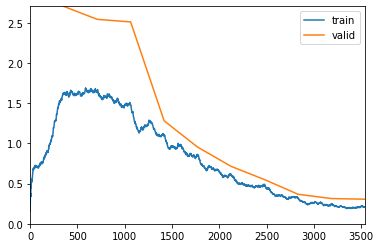

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet152_phase24.pth')

In [ ]:
#Unfreeze the model and full training
#Experiment5 by setting max_lr = slice(6e-4, 6e-3)
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet152_phase1')
learn.unfreeze()
random_seed(42,True)
learn.fit_one_cycle(10, max_lr = slice(6e-4, 6e-3), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet152_phase24', return_path = True)


epoch,train_loss,valid_loss,accuracy,time
0,0.612480,0.522690,0.848435,02:35
1,0.482807,0.572587,0.833608,02:34
2,0.404926,0.615140,0.832784,02:35
3,0.381809,0.683213,0.809308,02:34
4,0.322764,1.041803,0.768534,02:35
5,0.351257,0.824724,0.796952,02:35
6,0.411511,0.951620,0.760297,02:35
7,0.533671,0.866679,0.771829,02:34
8,0.678337,0.908797,0.775535,02:35
9,0.744939,1.409858,0.755354,02:34


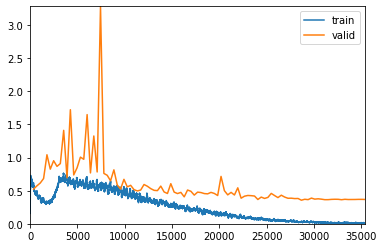

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet152_phase24-F.pth')

In [ ]:
#Unfreeze the model and full training
#Optimal Parameter: max_lr = slice(6e-4, 6e-3)--> Full Run: Epoch=100
from fastai.callbacks import EarlyStoppingCallback

learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet152_phase1')
learn.unfreeze()

# Callback to avoid over fitting
callback = EarlyStoppingCallback(learn,
                                  monitor = 'accuracy',
                                  patience = 2)   
   
random_seed(42,True)

learn.fit_one_cycle(100, max_lr = slice(6e-4, 6e-3), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet152_phase24-F', return_path = True)


In [ ]:
# Base Model Performance
learn1 = learn.load('/content/drive/MyDrive/894GroupProject/ResNet152_phase1')
random_seed(42,True)
val_preds1, val_targets1 = learn1.get_preds()
preds1 = val_preds1.tolist()
cls_preds1 = np.array([pred1.index(max(pred1))for pred1 in preds1])
precision1, recall1, fscore1, support1 = precision_recall_fscore_support(np.array(val_targets1), cls_preds1, average = 'weighted')
print('The precision score is', precision1, '\nThe recall score is', recall1, '\nThe fscore score is', fscore1)

The precision score is 0.9025976994881637 
The recall score is 0.8941515650741351 
The fscore score is 0.8935104763346718


In [ ]:
# Best Model Performance
learn2 = learn.load('/content/drive/MyDrive/894GroupProject/ResNet152_phase24-F')
random_seed(42,True)
val_preds2, val_targets2 = learn2.get_preds()
preds2 = val_preds2.tolist()
cls_preds2 = np.array([pred2.index(max(pred2))for pred2 in preds2])
precision2, recall2, fscore2, support2 = precision_recall_fscore_support(np.array(val_targets2), cls_preds2, average = 'weighted')
print('The precision score is', precision2, '\nThe recall score is', recall2, '\nThe fscore score is', fscore2)

The precision score is 0.9417259031818561 
The recall score is 0.9357495881383855 
The fscore score is 0.9360601123912092


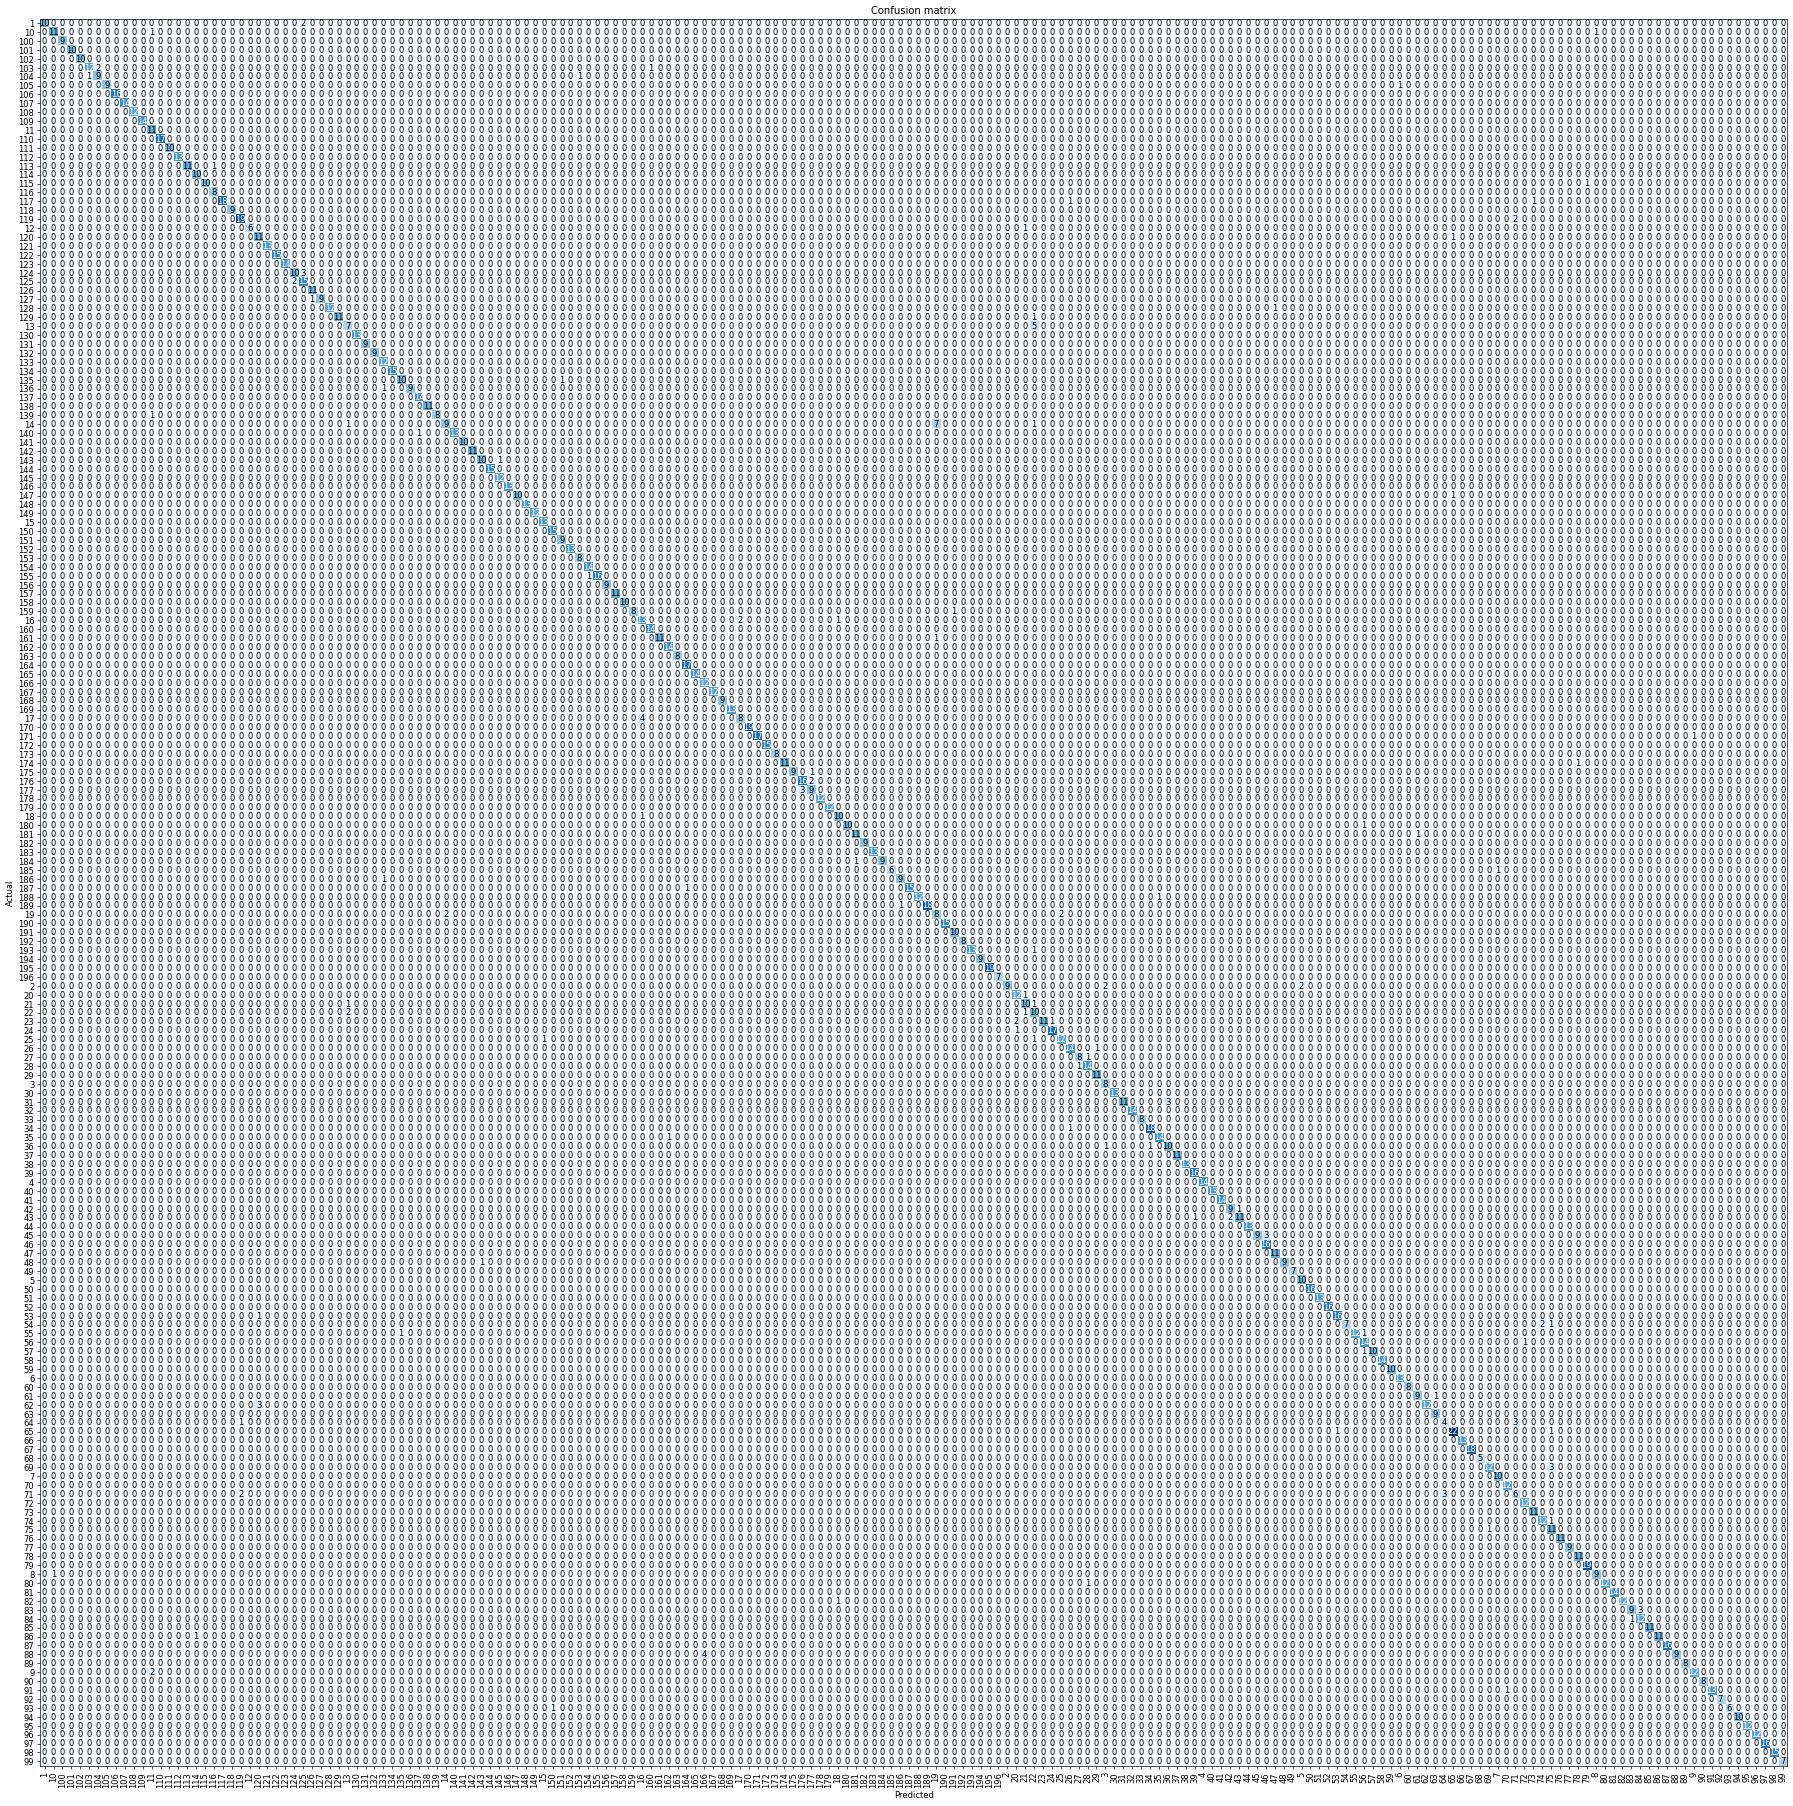

In [ ]:
# Confusion Matrix
random_seed(42,True)
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix(figsize = (30, 30), dpi = 60)

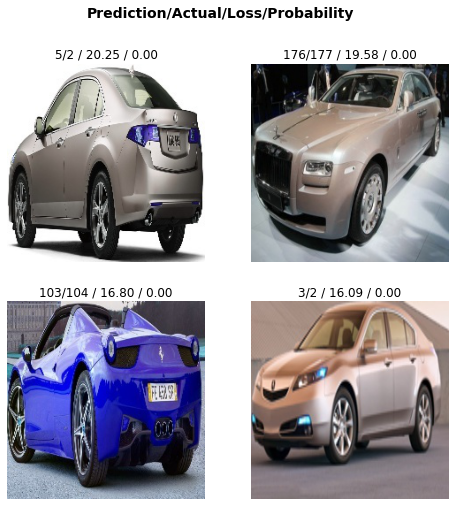

In [ ]:
interp.most_confused(min_val = 6)
interp.plot_top_losses(4, figsize = (8, 8))

In [ ]:
from tqdm import tqdm

In [ ]:
# Model Evaluation
df_test_new = pd.read_csv('/content/drive/MyDrive/Simcoe/894/Car dataset/df_test_new.csv')
actual_tup = df_test_new[['img_name','class']].to_records(index=False)
actual_tup = list(actual_tup)

preds = []
dataIndex = []
num_preds = len(actual_tup)
for i in tqdm(range(num_preds)):
    random_seed(42,True)
    p = learn2.predict(data.test_ds.x[i])
    preds.append(str(p[0]))
    dataIndex.append(str(learn2.data.test_ds.items[i]).split('/')[-1])

dataIndex1 = np.asarray(dataIndex)
preds = list(map(int, preds))
pred_tup = list(zip(dataIndex1,preds))
pred_tup.sort()

df_pred = pd.DataFrame(pred_tup,columns=['img_name','pred_class'])
df_valid = df_test_new.merge(df_pred, left_on='img_name', right_on='img_name')

feature_list1 = ['img_name','class','pred_class']
df_valid1 = df_valid[feature_list1]

df_valid1['diff'] = np.where(df_valid1['class'] == df_valid1['pred_class'],1,0)
accuracy = df_valid1['diff'].sum()/df_valid1.shape[0]
accuracy


precision, recall, fscore, support = precision_recall_fscore_support(df_valid1['class'].values, df_valid1['pred_class'].values, average = 'weighted')
print('The precision score is', precision, '\nThe recall score is', recall, '\nThe fscore score is', fscore, '\nThe accuracy score is', accuracy)

100%|██████████| 2427/2427 [17:41<00:00,  2.29it/s]

The precision score is 0.9371833256676564 
The recall score is 0.9316028018129378 
The fscore score is 0.9318793945399596 
The accuracy score is 0.9316028018129378



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
